# Recommendations with IBM

## Table of Contents

I. [Exploratory Data Analysis](#Exploratory-Data-Analysis)<br>
II. [Rank Based Recommendations](#Rank)<br>
III. [User-User Based Collaborative Filtering](#User-User)<br>
IV. [Content Based Recommendations (EXTRA - NOT REQUIRED)](#Content-Recs)<br>
V. [Matrix Factorization](#Matrix-Fact)<br>
VI. [Extras & Concluding](#conclusions)

In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import project_tests as t
import pickle

%matplotlib inline

df = pd.read_csv('data/user-item-interactions.csv')
df_content = pd.read_csv('data/articles_community.csv')
del df['Unnamed: 0']
del df_content['Unnamed: 0']

# Show df to get an idea of the data
df.head()

,article_id,title,email
0,1430.0,"using pixiedust for fast, flexible, and easier...",ef5f11f77ba020cd36e1105a00ab868bbdbf7fe7
1,1314.0,healthcare python streaming application demo,083cbdfa93c8444beaa4c5f5e0f5f9198e4f9e0b
2,1429.0,use deep learning for image classification,b96a4f2e92d8572034b1e9b28f9ac673765cd074
3,1338.0,ml optimization using cognitive assistant,06485706b34a5c9bf2a0ecdac41daf7e7654ceb7
4,1276.0,deploy your python model as a restful api,f01220c46fc92c6e6b161b1849de11faacd7ccb2


In [49]:
# Show df_content to get an idea of the data
df_content.head()

,doc_body,doc_description,doc_full_name,doc_status,article_id
0,Skip navigation Sign in SearchLoading...\r\n\r...,Detect bad readings in real time using Python ...,Detect Malfunctioning IoT Sensors with Streami...,Live,0
1,No Free Hunch Navigation * kaggle.com\r\n\r\n ...,"See the forest, see the trees. Here lies the c...",Communicating data science: A guide to present...,Live,1
2,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...,Here’s this week’s news in Data Science and Bi...,"This Week in Data Science (April 18, 2017)",Live,2
3,"DATALAYER: HIGH THROUGHPUT, LOW LATENCY AT SCA...",Learn how distributed DBs solve the problem of...,DataLayer Conference: Boost the performance of...,Live,3
4,Skip navigation Sign in SearchLoading...\r\n\r...,This video demonstrates the power of IBM DataS...,Analyze NY Restaurant data using Spark in DSX,Live,4


### <a class="anchor" id="Exploratory-Data-Analysis">Part I : Exploratory Data Analysis</a>

`1.` What is the distribution of how many articles a user interacts with in the dataset?  

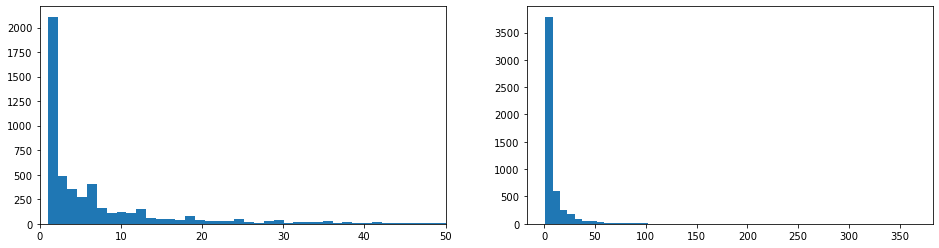

In [50]:
fig, ax = plt.subplots(ncols=2, figsize=(16,4))

# specify narrower x limits to better visualise distribution
ax[0].hist(df.groupby('email')['article_id'].count(), bins = 300)
ax[0].set_xlim(0,50)

ax[1].hist(df.groupby('email')['article_id'].count(), bins = 50);

In [51]:
user_interactions_count = df.groupby('email')['article_id'].count()
user_interactions_count.describe()

count    5148.000000
mean        8.930847
std        16.802267
min         1.000000
25%         1.000000
50%         3.000000
75%         9.000000
max       364.000000
Name: article_id, dtype: float64

In [52]:
median_val = 3# 50% of individuals interact with ____ number of articles or fewer.
max_views_by_user = 364# The maximum number of user-article interactions by any 1 user is ______.

`2.` Explore and remove duplicate articles from the **df_content** dataframe.  

In [53]:
df_content.loc[:,'article_id'].duplicated().sum()

5

In [54]:
# Find and explore duplicate articles
df_content[df_content.loc[:,'article_id'].duplicated(keep=False)]

,doc_body,doc_description,doc_full_name,doc_status,article_id
50,Follow Sign in / Sign up Home About Insight Da...,Community Detection at Scale,Graph-based machine learning,Live,50
221,* United States\r\n\r\nIBM® * Site map\r\n\r\n...,When used to make sense of huge amounts of con...,How smart catalogs can turn the big data flood...,Live,221
232,Homepage Follow Sign in Get started Homepage *...,"If you are like most data scientists, you are ...",Self-service data preparation with IBM Data Re...,Live,232
365,Follow Sign in / Sign up Home About Insight Da...,During the seven-week Insight Data Engineering...,Graph-based machine learning,Live,50
399,Homepage Follow Sign in Get started * Home\r\n...,Today’s world of data science leverages data f...,Using Apache Spark as a parallel processing fr...,Live,398
578,This video shows you how to construct queries ...,This video shows you how to construct queries ...,Use the Primary Index,Live,577
692,Homepage Follow Sign in / Sign up Homepage * H...,One of the earliest documented catalogs was co...,How smart catalogs can turn the big data flood...,Live,221
761,Homepage Follow Sign in Get started Homepage *...,Today’s world of data science leverages data f...,Using Apache Spark as a parallel processing fr...,Live,398
970,This video shows you how to construct queries ...,This video shows you how to construct queries ...,Use the Primary Index,Live,577
971,Homepage Follow Sign in Get started * Home\r\n...,"If you are like most data scientists, you are ...",Self-service data preparation with IBM Data Re...,Live,232


In [55]:
# Remove any rows that have the same article_id - only keep the first
df_content = df_content.drop_duplicates(subset='article_id', keep='first')

In [56]:
df_content.loc[:,'article_id'].duplicated().sum()

0

`3.` Use the cells below to find:

**a.** The number of unique articles that have an interaction with a user.  
**b.** The number of unique articles in the dataset (whether they have any interactions or not).<br>
**c.** The number of unique users in the dataset. (excluding null values) <br>
**d.** The number of user-article interactions in the dataset.

In [57]:
unique_articles = len(df.article_id.unique())# The number of unique articles that have at least one interaction
total_articles = df_content.article_id.unique().shape[0]# The number of unique articles on the IBM platform
unique_users = df.email.unique().shape[0]# The number of unique users
user_article_interactions = df.shape[0]# The number of user-article interactions

`4.` Use the cells below to find the most viewed **article_id**, as well as how often it was viewed.  After talking to the company leaders, the `email_mapper` function was deemed a reasonable way to map users to ids.  There were a small number of null values, and it was found that all of these null values likely belonged to a single user (which is how they are stored using the function below).

In [58]:
df.groupby('article_id')['email'].count().sort_values(ascending=False).head(1)

article_id
1429.0    937
Name: email, dtype: int64

In [59]:
most_viewed_article_id = '1429.0'# The most viewed article in the dataset as a string with one value following the decimal 
max_views = 937# The most viewed article in the dataset was viewed how many times?

In [60]:
# Run this cell to map the user email to a user_id column and remove the email column

def email_mapper():
    coded_dict = dict()
    cter = 1
    email_encoded = []
    
    for val in df['email']:
        if val not in coded_dict:
            coded_dict[val] = cter
            cter+=1
        
        email_encoded.append(coded_dict[val])
    return email_encoded

email_encoded = email_mapper()
del df['email']
df['user_id'] = email_encoded

# show header
df.head()

,article_id,title,user_id
0,1430.0,"using pixiedust for fast, flexible, and easier...",1
1,1314.0,healthcare python streaming application demo,2
2,1429.0,use deep learning for image classification,3
3,1338.0,ml optimization using cognitive assistant,4
4,1276.0,deploy your python model as a restful api,5


In [61]:
df.head(1).title.values

array(['using pixiedust for fast, flexible, and easier data analysis and experimentation'],
      dtype=object)

In [62]:
# first user id is a fake
df.user_id.unique().shape[0] - 1

5148

In [63]:
df.article_id = df.article_id.astype(str)
df_content.article_id = df_content.article_id.astype(str)

In [64]:
## If you stored all your results in the variable names above, 
## you shouldn't need to change anything in this cell

sol_1_dict = {
    '`50% of individuals have _____ or fewer interactions.`': median_val,
    '`The total number of user-article interactions in the dataset is ______.`': user_article_interactions,
    '`The maximum number of user-article interactions by any 1 user is ______.`': max_views_by_user,
    '`The most viewed article in the dataset was viewed _____ times.`': max_views,
    '`The article_id of the most viewed article is ______.`': most_viewed_article_id,
    '`The number of unique articles that have at least 1 rating ______.`': unique_articles,
    '`The number of unique users in the dataset is ______`': unique_users,
    '`The number of unique articles on the IBM platform`': total_articles
}

# Test your dictionary against the solution
t.sol_1_test(sol_1_dict)

Oops! It looks like the value associated with: `The number of unique users in the dataset is ______` wasn't right. Try again.  It might just be the datatype.  All of the values should be ints except the article_id should be a string.  Let each row be considered a separate user-article interaction.  If a user interacts with an article 3 times, these are considered 3 separate interactions.

  Notice you may also find the number of unique users as 5149 if you count the null user.  However, this is hard to catch without mapping first!


### <a class="anchor" id="Rank">Part II: Rank-Based Recommendations</a>

In [65]:
def get_top_articles(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    sorted_articles = df.groupby('title').count().iloc[:,0].sort_values(ascending=False)
    top_articles = list(sorted_articles.head(n).index)
    
    return top_articles # Return the top article titles from df (not df_content)

def get_top_article_ids(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    sorted_articles = df.groupby('article_id').count().iloc[:,0].sort_values(ascending=False)
    top_articles = list(sorted_articles.head(n).index)
 
    return top_articles # Return the top article ids

In [66]:
# Test your function by returning the top 5, 10, and 20 articles
top_5 = get_top_articles(5)
top_10 = get_top_articles(10)
top_20 = get_top_articles(20)

# Test each of your three lists from above
t.sol_2_test(get_top_articles)

Your top_5 looks like the solution list! Nice job.
Your top_10 looks like the solution list! Nice job.
Your top_20 looks like the solution list! Nice job.


### <a class="anchor" id="User-User">Part III: User-User Based Collaborative Filtering</a>

In [67]:
# create the user-article matrix with 1's and 0's

def create_user_item_matrix(df):
    '''
    INPUT:
    df - pandas dataframe with article_id, title, user_id columns
    
    OUTPUT:
    user_item - user item matrix 
    
    Description:
    Return a matrix with user ids as rows and article ids on the columns with 1 values where a user interacted with 
    an article and a 0 otherwise
    '''
    # create user item matrix
    user_item = df.groupby(['user_id','article_id'])['title'].count().unstack()
    # change NaN to 0 and numbers > 0 to 1
    user_item = (user_item > 0)*1
    # ensure datatype is string
    user_item.columns = user_item.columns.astype(str)
    
    return user_item # return the user_item matrix 

user_item = create_user_item_matrix(df)

In [68]:
## Tests: You should just need to run this cell.  Don't change the code.
assert user_item.shape[0] == 5149, "Oops!  The number of users in the user-article matrix doesn't look right."
assert user_item.shape[1] == 714, "Oops!  The number of articles in the user-article matrix doesn't look right."
assert user_item.sum(axis=1)[1] == 36, "Oops!  The number of articles seen by user 1 doesn't look right."
print("You have passed our quick tests!  Please proceed!")

You have passed our quick tests!  Please proceed!


In [69]:
def find_similar_users(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user_id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    similar_users - (list) an ordered list where the closest users (largest dot product users)
                    are listed first
    
    Description:
    Computes the similarity of every pair of users based on the dot product
    Returns an ordered
    
    '''
    # compute similarity of each user to the provided user
    similarities = np.dot(user_item.loc[user_id,:],np.transpose(user_item))

    # sort by similarity
    # create list of just the ids
    similarities_ids = np.argsort(similarities)[::-1]+1
    # remove the own user's id
    most_similar_users = similarities_ids[1:]
    return most_similar_users # return a list of the users in order from most to least similar
        

In [70]:
# Do a spot check of your function
print("The 10 most similar users to user 1 are: {}".format(find_similar_users(1)[:10]))
print("The 5 most similar users to user 3933 are: {}".format(find_similar_users(3933)[:5]))
print("The 3 most similar users to user 46 are: {}".format(find_similar_users(46)[:3]))

The 10 most similar users to user 1 are: [3933   23 3782  203 4459  131 3870   46 4201 5041]
The 5 most similar users to user 3933 are: [3933   23 3782 4459  203]
The 3 most similar users to user 46 are: [  46   23 3782]


`3.` Now that you have a function that provides the most similar users to each user, you will want to use these users to find articles you can recommend.  Complete the functions below to return the articles you would recommend to each user. 

In [71]:
def get_article_names(article_ids, df=df):
    '''
    INPUT:
    article_ids - (list) a list of article ids
    df - (pandas dataframe) df as defined at the top of the notebook
    
    OUTPUT:
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the title column)
    '''
    article_names = list(set(df[df.article_id.isin(article_ids)].title))
    
    return article_names # Return the article names associated with list of article ids


def get_user_articles(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    article_ids - (list) a list of the article ids seen by the user
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the doc_full_name column in df_content)
    
    Description:
    Provides a list of the article_ids and article titles that have been seen by a user
    '''
    # get user ids where they have interacted with an article
    article_ids = list(user_item.loc[user_id, :][user_item.loc[user_id, :]==1].index)
    # get article names
    article_names = get_article_names(article_ids)
    
    
    return article_ids, article_names # return the ids and names


def user_user_recs(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    Users who are the same closeness are chosen arbitrarily as the 'next' user
    
    For the user where the number of recommended articles starts below m 
    and ends exceeding m, the last items are chosen arbitrarily
    
    '''
    # find similar m similar user ids
    similar_user_ids = find_similar_users(user_id)[:m]
    
    recs = []
    # for each user id in the similar users
    for user_id in similar_user_ids:
        # get similar articles
        article_ids = get_user_articles(user_id)[0]
        # append to the recommendations
        recs = recs + article_ids
        # break if the recommendations list is larger than 10
        if len(recs) > 10:
            recs = recs[:10] # filter so that the list is no larger than 10 before breaking
            break
    
    return recs # return your recommendations for this user_id    

In [72]:
# Check Results
get_article_names(user_user_recs(1, 10)) # Return 10 recommendations for user 1

['access db2 warehouse on cloud and db2 with python',
 'putting a human face on machine learning',
 'country statistics: life expectancy at birth',
 'gosales transactions for naive bayes model',
 'categorize urban density',
 'finding optimal locations of new store using decision optimization',
 'tensorflow quick tips',
 'apache spark lab, part 1: basic concepts',
 'classify tumors with machine learning',
 'predict loan applicant behavior with tensorflow neural networking']

In [73]:
# Test your functions here - No need to change this code - just run this cell
assert set(get_article_names(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_article_names(['1320.0', '232.0', '844.0'])) == set(['housing (2015): united states demographic measures','self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_user_articles(20)[0]) == set(['1320.0', '232.0', '844.0'])
assert set(get_user_articles(20)[1]) == set(['housing (2015): united states demographic measures', 'self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook'])
assert set(get_user_articles(2)[0]) == set(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])
assert set(get_user_articles(2)[1]) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis'])
print("If this is all you see, you passed all of our tests!  Nice job!")

If this is all you see, you passed all of our tests!  Nice job!


In [74]:
def get_top_sorted_users(user_id, df=df, user_item=user_item):
    '''
    INPUT:
    user_id - (int)
    df - (pandas dataframe) df as defined at the top of the notebook 
    user_item - (pandas dataframe) matrix of users by articles: 
            1's when a user has interacted with an article, 0 otherwise
    
            
    OUTPUT:
    neighbors_df - (pandas dataframe) a dataframe with:
                    neighbor_id - is a neighbor user_id
                    similarity - measure of the similarity of each user to the provided user_id
                    num_interactions - the number of articles viewed by the user - if a u
                    
    Other Details - sort the neighbors_df by the similarity and then by number of interactions where 
                    highest of each is higher in the dataframe
     
    '''
    # compute similarity using dot product
    similarities = np.dot(user_item.loc[user_id,:],np.transpose(user_item))
    # define the neighbour ids
    neighbor_ids = user_item.index
    # count the number of neighbour interactions
    num_interactions = df.groupby('user_id')['article_id'].count()
    # create dataframe with neighbour ids, their similarity to the specified user id and the number of interactions
    neighbors_df = pd.DataFrame({'neighbor_id': neighbor_ids, 'similarity': similarities,
                             'num_interactions': num_interactions})
    # filter the dataframe to not include the original user_id
    neighbors_df = neighbors_df.query('neighbor_id != @user_id')
    
    # sort the dataframe by similarity and interaction number
    neighbors_df = neighbors_df.sort_values(by=['similarity', 'num_interactions'], ascending=False)
    
    return neighbors_df # Return the dataframe specified in the doc_string


def user_user_recs_part2(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user by article id
    rec_names - (list) a list of recommendations for the user by article title
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    * Choose the users that have the most total article interactions 
    before choosing those with fewer article interactions.

    * Choose articles with the articles with the most total interactions 
    before choosing those with fewer total interactions. 
   
    '''
    # Your code here
    neighbors_df = get_top_sorted_users(user_id)
    
    recs = []
    # for each id in the neighbours id
    for id in neighbors_df.neighbor_id:
        neighbor_df = df.query('user_id == @id') # filter to just get a dataframe for the neighbour id only
        top_articles = get_top_article_ids(m, neighbor_df)# find all articles that the neighbour has engaged with
        recs = recs + top_articles # add to the recommendations
        if len(recs) > 10: # stop if we have more than 10 recommendations
            recs = recs[:10] # filter for only 10 articles.
            break
    
    # get the article names
    rec_names = get_article_names(recs)
    
    return recs, rec_names

In [75]:
# Quick spot check - don't change this code - just use it to test your functions
rec_ids, rec_names = user_user_recs_part2(20, 10)
print("The top 10 recommendations for user 20 are the following article ids:")
print(rec_ids)
print()
print("The top 10 recommendations for user 20 are the following article names:")
print(rec_names)

The top 10 recommendations for user 20 are the following article ids:
['1427.0', '1330.0', '1276.0', '1278.0', '1172.0', '1360.0', '793.0', '1329.0', '1170.0', '1296.0']

The top 10 recommendations for user 20 are the following article names:
['ingest data from message hub in a streams flow', 'deploy your python model as a restful api', 'use xgboost, scikit-learn & ibm watson machine learning apis', '10 powerful features on watson data platform, no coding necessary', 'pixieapp for outlier detection', 'develop a scala spark model on chicago building violations', 'apache spark lab, part 3: machine learning', 'apache spark lab, part 1: basic concepts', 'fortune 100 companies', 'insights from new york car accident reports']


`5.` Use your functions from above to correctly fill in the solutions to the dictionary below.  Then test your dictionary against the solution.  Provide the code you need to answer each following the comments below.

In [76]:
### Tests with a dictionary of results

user1_most_sim = find_similar_users(1)[0]# Find the user that is most similar to user 1 
user131_10th_sim = find_similar_users(131)[9]# Find the 10th most similar user to user 131

In [77]:
## Dictionary Test Here
sol_5_dict = {
    'The user that is most similar to user 1.': user1_most_sim, 
    'The user that is the 10th most similar to user 131': user131_10th_sim,
}

t.sol_5_test(sol_5_dict)

This all looks good!  Nice job!


`6.` If we were given a new user, which of the above functions would you be able to use to make recommendations?  Explain.  Can you think of a better way we might make recommendations?  Use the cell below to explain a better method for new users.

- I would use the get_top_article functions.
- Given that we wouldn't have any information on the new user and their preferences, this would be the best option.

- We could perhaps recommend top articles over a recent time period, so that articles which had a lot of engagement in the past but may no longer be relevant are not as highly weighted.

`7.` Using your existing functions, provide the top 10 recommended articles you would provide for the a new user below.  You can test your function against our thoughts to make sure we are all on the same page with how we might make a recommendation.

In [78]:
new_user = '0.0'

# What would your recommendations be for this new user '0.0'?  As a new user, they have no observed articles.
# Provide a list of the top 10 article ids you would give to 
new_user_recs = get_top_article_ids(10)# Your recommendations here

In [79]:
assert set(new_user_recs) == set(['1314.0','1429.0','1293.0','1427.0','1162.0','1364.0','1304.0','1170.0','1431.0','1330.0']), "Oops!  It makes sense that in this case we would want to recommend the most popular articles, because we don't know anything about these users."

print("That's right!  Nice job!")

That's right!  Nice job!


### <a class="anchor" id="Content-Recs">Part IV: Content Based Recommendations</a>

In [80]:
# load libraries necessary for NLP
import re

# load nltk libraries
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk import pos_tag

# load sklearn libraries
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.pipeline import Pipeline


def tokenize(text):
    
    # remove punctuation
    pattern = '[^A-Za-z0-9]'
    text = re.sub(pattern, ' ', text)

    # convert to lowercase
    text = text.lower().strip()

    # tokenize
    words = word_tokenize(text)

    # remove stopwords (common words that don't add much meaning)
    stop_words = stopwords.words('english')
    words = [word for word in words if word not in stop_words]

    # lemmatize nouns (convert words to their roots)
    words = [WordNetLemmatizer().lemmatize(word, pos='n') for word in words]

    # lemmatize verbs
    words = [WordNetLemmatizer().lemmatize(word, pos='v') for word in words]

    # stem words (reduce words to their stem)
    words = [PorterStemmer().stem(word) for word in words]

    return words

# create pipeline using CountVectorizer and TFIDF
pipeline = Pipeline([
                    ('vect',CountVectorizer(tokenizer=tokenize)),
                    ('tfidf', TfidfTransformer())
                    ])

# clean n/a
clean_data = df.title.fillna('').unique()

# fit pipeline
doc_words = pipeline.fit_transform(clean_data).toarray()

In [81]:
def find_similar_articles(article_id, doc_words=doc_words):
    '''
    INPUT:
    user_id - (int) a user_id
    doc_words - (numpy matrix) matrix of document descriptions by words: 
                Takes continuous values between 0 and 1 because TFIDF has been applied.
    
    OUTPUT:
    similar_documents - (list) an ordered list where the closest articles (largest dot product descriptions)
                    are listed first
    
    Description:
    Computes the similarity of every pair of article descriptions based on the dot product
    Returns an ordered list of the above
    
    '''
    
    # get row index for article
    idx = np.where(df.article_id == article_id)[0][0]
 
    # compute similarity of each article to the provided article
    similarities = np.dot(doc_words[idx,:],np.transpose(doc_words))

    # sort by similarity
    # create list of just the ids
    similarities_ids = np.argsort(similarities)[::-1]
    # remove the article id
    most_similar_arts = list(similarities_ids[1:])
    return most_similar_arts # return a list of the articles in order from most to least similar


def get_top_unique_article_names(n=10, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''    
    # filter and return most engaged with articles by unique user
    unique_interactions_df = df.drop_duplicates(subset=['article_id', 'user_id'])
    sorted_articles = unique_interactions_df.groupby(['article_id','title']).count().iloc[:,0].sort_values(ascending=False)
    top_articles = list(sorted_articles.reset_index().head(n).title.values)
 
    return top_articles # Return the top article ids

In [82]:
def make_content_recs(article_id=None, m=10):
    '''
    INPUT:
    article_id - the article id that should be used to calculate which other articles are most similar.
    m - the number of recommendations to return
    
    OUTPUT:
    top_articles - a list of the top recommended articles.
    
    Description:
    This function will recommend the top m articles by:
    - using natural language processing to determine which titles are 
    most similar to the specified article id title
    - returning the articles with the most engagement from unique users.
    '''
    # if article isn't None
    if article_id:
        # find and return most similar articles
        top_articles_idx = find_similar_articles(article_id)[:m]
        top_articles = list(df.iloc[top_articles_idx].title.values)
        return top_articles
    else: # else return most engaged with articles
        top_articles = get_top_unique_article_names(n=m)
        return top_articles    

- The content-based recommender works by analysing article titles and using natural language processing to identify which article titles are most similar to each other.
- If no article id is specified, the recommender will return the articles with the most engagement from unique users.
- The similarity matching could be improved by using the document descriptions or bodies instead of title. However, the df_content dataset was not complete enough to do this.

In [83]:
# make recommendations for a brand new user
make_content_recs()

['insights from new york car accident reports',
 'use deep learning for image classification',
 'predicting churn with the spss random tree algorithm',
 'healthcare python streaming application demo',
 'total population by country',
 'visualize car data with brunel',
 'customer demographics and sales',
 'use xgboost, scikit-learn & ibm watson machine learning apis',
 'analyze accident reports on amazon emr spark',
 'deep learning with tensorflow course by big data university']

In [84]:
# make a recommendations for a user who only has interacted with article id '1427.0'
make_content_recs('1427.0')

['use sql with data in hadoop python',
 'probabilistic graphical models tutorial\u200a—\u200apart 1 – stats and bots',
 'insights from new york car accident reports',
 'percentage of internet users by country',
 'analyze accident reports on amazon emr spark',
 'visualize data with the matplotlib library',
 '10 must attend data science, ml and ai conferences in 2018',
 'enjoy python 3.5 in jupyter notebooks',
 'gosales transactions for naive bayes model',
 'insights from new york car accident reports']

### <a class="anchor" id="Matrix-Fact">Part V: Matrix Factorization</a>

In [85]:
# Load the matrix
user_item_matrix = pd.read_pickle('user_item_matrix.p')

In [86]:
# quick look at the matrix
user_item_matrix.head()

article_id,0.0,100.0,1000.0,1004.0,1006.0,1008.0,101.0,1014.0,1015.0,1016.0,...,977.0,98.0,981.0,984.0,985.0,986.0,990.0,993.0,996.0,997.0
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### Perform SVD

In [87]:
# Perform SVD on the User-Item Matrix
u, s, vt = np.linalg.svd(user_item_matrix)# use the built in to get the three matrices

#### Comment
- Here we are performing SVD using a closed-form solution, whilst in the lesson we used the Funk SVD gradient descent algorithm.
- This is possible because we are constructing a matrix with 1 and 0 values i.e. there are no NaN values and the matrix is not sparse.

#### Choose Latent Features

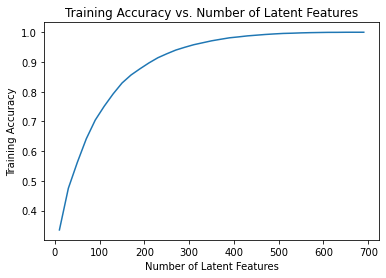

In [88]:
num_latent_feats = np.arange(10,700+10,20)
sum_errs = []

for k in num_latent_feats:
    # restructure with k latent features
    s_new, u_new, vt_new = np.diag(s[:k]), u[:, :k], vt[:k, :]
    
    # take dot product
    user_item_est = np.around(np.dot(np.dot(u_new, s_new), vt_new))
    
    # compute error for each prediction to actual value
    diffs = np.subtract(user_item_matrix, user_item_est)
    
    # total errors and keep track of them
    err = np.sum(np.sum(np.abs(diffs)))
    sum_errs.append(err)
    
    
plt.plot(num_latent_feats, 1 - np.array(sum_errs)/df.shape[0]);
plt.xlabel('Number of Latent Features');
plt.ylabel('Training Accuracy');
plt.title('Training Accuracy vs. Number of Latent Features');

#### Split into training and test set

Questions to answer:

* How many users can we make predictions for in the test set?  
* How many users are we not able to make predictions for because of the cold start problem?
* How many articles can we make predictions for in the test set?  
* How many articles are we not able to make predictions for because of the cold start problem?

In [106]:
df_train = df.head(40000)
df_test = df.tail(5993)

def create_test_and_train_user_item(df_train, df_test):
    '''
    INPUT:
    df_train - training dataframe
    df_test - test dataframe
    
    OUTPUT:
    user_item_train - a user-item matrix of the training dataframe 
                      (unique users for each row and unique articles for each column)
    user_item_test - a user-item matrix of the testing dataframe 
                    (unique users for each row and unique articles for each column)
    test_idx - all of the test user ids
    test_arts - all of the test article ids
    
    '''
    # create training and test datasets
    user_item_train = (df_train.groupby(['user_id','article_id'])['title'].count().unstack() > 0)*1
    user_item_test = (df_test.groupby(['user_id','article_id'])['title'].count().unstack() > 0)*1
    
    # identify test users and articles
    test_idx = user_item_test.index
    test_arts = user_item_test.columns
    
    return user_item_train, user_item_test, test_idx, test_arts

user_item_train, user_item_test, test_idx, test_arts = create_test_and_train_user_item(df_train, df_test)

In [90]:
possible_user_test_preds = len(set(user_item_train.index).intersection(user_item_test.index))
possible_user_test_preds

20

In [91]:
len(user_item_test) - possible_user_test_preds

662

In [92]:
possible_article_test_preds = len(set(user_item_train.columns).intersection(user_item_test.columns))
possible_article_test_preds

574

In [93]:
len(user_item_test.columns) - possible_article_test_preds

0

In [94]:
# Replace the values in the dictionary below
a = 662 
b = 574 
c = 20 
d = 0 


sol_4_dict = {
    'How many users can we make predictions for in the test set?': c, 
    'How many users in the test set are we not able to make predictions for because of the cold start problem?': a, 
    'How many movies can we make predictions for in the test set?': b,
    'How many movies in the test set are we not able to make predictions for because of the cold start problem?': d
}

t.sol_4_test(sol_4_dict)

Awesome job!  That's right!  All of the test movies are in the training data, but there are only 20 test users that were also in the training set.  All of the other users that are in the test set we have no data on.  Therefore, we cannot make predictions for these users using SVD.


`5.` Now use the **user_item_train** dataset from above to find U, S, and V transpose using SVD. Then find the subset of rows in the **user_item_test** dataset that you can predict using this matrix decomposition with different numbers of latent features to see how many features makes sense to keep based on the accuracy on the test data. This will require combining what was done in questions `2` - `4`.

Use the cells below to explore how well SVD works towards making predictions for recommendations on the test data.  

#### Predict on test set

- Decide on how many latent features to keep

In [95]:
# fit SVD on the user_item_train matrix
u_train, s_train, vt_train = np.linalg.svd(user_item_train)# fit svd similar to above

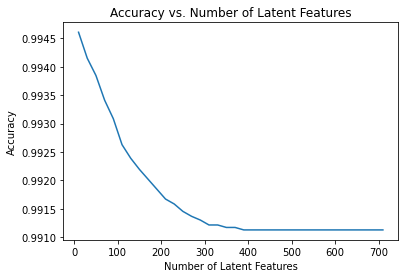

In [139]:
num_latent_feats = np.arange(10, 700+20, 20)
sum_errs = []

# define test indices
test_ids = list(set(user_item_test.index).intersection(user_item_train.index))

# define test articles
test_cols = list(set(user_item_test.columns).intersection(user_item_train.columns))
test_cols_idx = user_item_train.columns.isin(test_cols)

# filter test data for relevant test ids
user_item_test_to_pred = user_item_test[user_item_test.index.isin(test_ids)]

for k in num_latent_feats:
    # restructure with k latent features
    test_id_idx = np.where(user_item_train.index.isin(test_ids))
    u_test_pred, s_test_pred, vt_test_pred = u_train[test_id_idx, :k], np.diag(s_train[:k]), vt_train[:k, :]

    # take dot product
    user_item_pred = np.around(np.dot(np.dot(u_test_pred, s_test_pred), vt_test_pred))
    
    # reduce to relevant article columns
    user_item_pred = user_item_pred[0][:,test_cols_idx]

    # compute error for each prediction to actual value
    diffs = np.subtract(user_item_test_to_pred, user_item_pred)

    err = np.sum(np.sum(np.abs(diffs)))
    sum_errs.append(err)
    
plt.plot(num_latent_feats, 1 - np.array(sum_errs)/df.shape[0]);
plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy');
plt.title('Accuracy vs. Number of Latent Features');

#### Comment
- The accuracy achieved is very high with few latent features. This is because the model has seen this data before and has been trained on it. However, this only takes into account 20 testing examples.
- The chart shows the accuracy decreases as the number of latent features increases. This is likely due to overfitting to the training data.

- To test the recommendation system, I would either:
    - deploy the system live in an A/B test where one set of users are given the new recommendations and a control set of users are shown the old recommendations. You could then track engagement metrics such as number of clicks or time spent on the article for both recommendation systems.
    - use the recommendation system to make predictions about which articles users will appreciate and engage with. You could then compare this later down the line with the actual articles they engaged with.

In [97]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Recommendations_with_IBM.ipynb'])

1